In [25]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings 
warnings.filterwarnings('ignore')
import time

# Check datasets

## Read dataset

In [26]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [27]:
print(df_train.shape, df_test.shape)

# train, test set의 행, 열 count

(9557, 143) (23856, 142)


In [28]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [29]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


## Make description df

In [30]:
# 생략

## Check null data

In [31]:
# null count
total = df_train.isnull().sum().sort_values(ascending=False)
# null percentage
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
SQBmeaned,5,0.052318
meaneduc,5,0.052318
Id,0,0.000000
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [32]:
df_train[['edjefa','edjefe']]

,edjefa,edjefe
0,no,10
1,no,12
2,11,no
3,no,11
4,no,11
...,...,...
9552,no,9
9553,no,9
9554,no,9
9555,no,9


## Fill missing values

In [33]:
# eduction = yes & person = 가장 이면 escolari의 년수로 채움

df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# edjefa = 가정의 가장이 여성, edjefe = 가정의 가장이 남성이면 모두 4로 치환
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# 'edjef' 피처 생성: edjefa, edjefe 중 max 값
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

#
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

**rez_esz, SQBmeaned**
* rez_esc : 학창시절 몇 년 뒤 -> 0으로 채움
* SQBmeaned : 성인의 교육기간 평균 제곱 -> 0으로 채움

In [34]:
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

In [35]:
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

**meaneduc**
* meaneduc : 성인의 평균 교육기간 -> 0으로 채움

In [36]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

**v18q1**
* v18q1 : 가정이 소유한 태블릿 수 

    v18q = 1 이면 v18q1은 1~6의 정수값을 갖고

    v18q = 0 이면 v18q1 = NaN

In [37]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [38]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [39]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

* v2a1 : 가정이 소유한 태블릿 수
* tipovivi3 = 0이면 v2a1 = NaN -> 0으로 채움

In [40]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

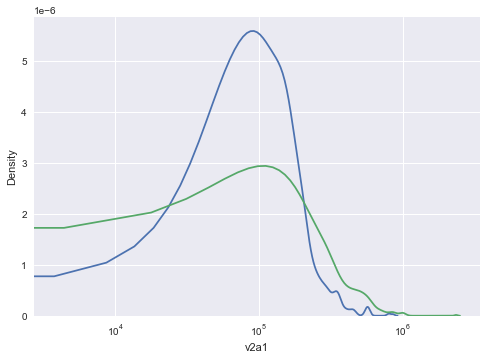

In [41]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label='Monthly rent payment of household(rented=1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'], label='Monthly rent payment of household(rented=0)')
plt.xscale('log')
plt.show()

In [42]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [43]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
v2a1,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_mayor,0,0.0
hogar_total,0,0.0


In [44]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
hogar_mayor,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
idhogar,0,0.0
hogar_nin,0,0.0
hogar_adul,0,0.0
hogar_total,0,0.0
parentesco8,0,0.0


결측값 모두 채움!

# Feature engineering

## Object features

속성이 object인 피처들을 살펴보자

In [45]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [46]:
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

**dependency**

In [47]:
# Na로 되어있는 값들은 제곱값의 제곱근으로 채우자
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

**edjefe**
* 남성 가장의 교육년수 (based on the interaction of escolari(교육년수))
* yes -> 1, no -> 0으로 대체

In [48]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

**edjefa**
* 여성 가장의 교육년수
* yes -> 1, no -> 0으로 대체

In [49]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [52]:
# 가장에 대한 컬럼 중 더 큰 값으로 edjef(성별무관컬럼)를 대체
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

**roof and electricity**
* I refered to https://www.kaggle.com/mineshjethva/exploratory-data-analysis-lightgbm. Thanks!
(무슨 내용인지 모르겠음 나중에 보기)

In [53]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x),axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x),axis=1)
df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x),axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x),axis=1)

## Extract cat features

continuous -> categorical feature 만들기

In [57]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

## Make new features using continuous features

In [60]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [61]:
print('There are {} continuous features'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 'description'].values))

There are 37 continuous features


NameError: name 'description' is not defined

* hhsize : household size
* tamhog : size of the household

    -> 두 변수의 차이가 뭔데? 불분명함. tamhog를 드롭하자

In [63]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

**Squared features**
* 많은 제곱 피쳐들이 있음.
* lightgbm 같은 트리모형은 제곱 피쳐들을 필요로 하지 않음.
* 그런데 이 커널에서는 피처를 필터링 하는 모델로 lightgbm을 사용하고 싶음

**Family features**
* hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari
* Family size features (substract, ratio)

In [64]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [65]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [66]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [67]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [68]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [69]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']  

In [70]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [71]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

* "가정 내에 총 persons 수" != "가정 내에 총 individuals 수" 임을 알 수 있음.
* 좀 이상하지만 지금은 keep it.

In [72]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

9509

**Rent per family features**
* shap를 이용해서 피쳐의 수를 줄일 것이므로, 일단 많은 피쳐들을 만들자!

In [73]:
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v2a1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v2a1'] / df_train[col]
    df_test[new_col_name] = df_test['v2a1'] / df_test[col]

* Ratio feature들은 무한대의 값을 가질 수 있으므로 0으로 채우자

In [74]:
for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

**Room per family features**

In [75]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rooms'] / df_train[col]
    df_test[new_col_name] = df_test['rooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

**BedRoom per family features**

In [76]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('bedrooms', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['bedrooms'] / df_train[col]
    df_test[new_col_name] = df_test['bedrooms'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [77]:
print(df_train.shape, df_test.shape) # To check the same number of features between train and test (target is there in train)

(9557, 220) (23856, 219)


**Tabulet per family features**

In [78]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('v18q1', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['v18q1'] / df_train[col]
    df_test[new_col_name] = df_test['v18q1'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

**phone per family features**

In [79]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('qmobilephone', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['qmobilephone'] / df_train[col]
    df_test[new_col_name] = df_test['qmobilephone'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

**rez_esc(졸업 이후 년도) per family features**

In [80]:
new_feats = []
for col in family_size_features:
    new_col_name = 'new_{}_per_{}'.format('rez_esc', col)
    new_feats.append(new_col_name)
    df_train[new_col_name] = df_train['rez_esc'] / df_train[col]
    df_test[new_col_name] = df_test['rez_esc'] / df_test[col]

for col in new_feats:
    df_train[col].replace([np.inf], np.nan, inplace=True)
    df_train[col].fillna(0, inplace=True)
    
    df_test[col].replace([np.inf], np.nan, inplace=True)
    df_test[col].fillna(0, inplace=True)

In [81]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

**Rich features**
* 더 부유할수록, 더 많은 수의 휴대폰과 태블릿을 소유함

In [82]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

* wall, roof, floor이 아마도 주요한 factor일 것.
* 각각의 것들을 곱하자. 왜냐하면 이들은 binary category 피쳐들.
* so mulitification of each features generates new categorical features (?)

In [83]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* 세 개의 피쳐들을 이용해서 조합

In [84]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [85]:
print(df_train.shape, df_test.shape)

(9557, 322) (23856, 321)


* electricity와 energy feature 섞기 -> energy feature

In [86]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* toilet과 rubbish disposal feature 섞기 -> other_infra features

In [87]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* toilet과 water provision features 섞기 -> water features

In [88]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [89]:
print(df_train.shape, df_test.shape)

(9557, 383) (23856, 382)


* education과 area features 섞기 -> education_zone_features

In [90]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* region과 education 섞기

In [91]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [92]:
print(df_train.shape, df_test.shape)

(9557, 455) (23856, 454)


* wall material과 roof, floor, wall 섞기

In [93]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col1 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [94]:
print(df_train.shape, df_test.shape)

(9557, 731) (23856, 730)


* Wow! 어떤 aggregation features(집계함수, 통계함수)도 없이 446개의 피쳐를 갖게 됨.
* 이제 필요 없는 것들은 지우자

**Remove feature with only one value**
* 1개의 값만 있는 변수는 제거하기

In [95]:
cols_with_only_one_value = []
for col in df_train.columns:
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

* Let's remove them!

In [96]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

**Check whether both train and test have same features**

In [97]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [98]:
(cols_train == cols_test).sum() == len(cols_train)

True

## aggregation features
* 이번 대회에서, 각각의 샘플들은 특정한 가정 구성원들임(idhogar).
* 따라서, 'idhogar(가구 수준 식별자)' 값에 근거하여 aggregate하자.

**Aggregation for family features**

In [113]:
def max_min(x):
    return x.max() - x.min()

**idhogar 그룹 별 family_size_feature에 대해 aggregation 값(mean~) 계산하자**
* **family_size_features :**
    * 'adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize'
* **aggregation functions :**
    * mean, std, min, max, sum, count, max-min

In [100]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    # 'mean','std','min','max','sum','count',max_min에 대해 for문 수행
    for i, function in enumerate(['mean','std','min','max','sum','count',max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new_' + 'max_min'
        else:
            new_col = item + '_new_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.42s/it]

new aggregate train set has 2988 rows, and 105 features
new aggregate test set has 7352 rows, and 105 features


* 결과적으로 105개 피쳐 생성됨.
* train은 2988개, test는 7352개의 idhogar 그룹이 있는 것으로 볼 수 있음.

In [123]:
agg_train.head(2)

,idhogar,adult_new_mean,adult_new_std,adult_new_min,adult_new_max,adult_new_sum,adult_new_count,adult_new_max_min,hogar_adul_new_mean,hogar_adul_new_std,...,edjef_new1_sum,escolari_new2_max_min,age_new2_max_min,escolari_age_new2_max_min,dependency_new2_max_min,bedrooms_new2_max_min,overcrowding_new2_max_min,rooms_new2_max_min,qmobilephone_new2_max_min,v18q1_new2_max_min
0,001ff74ca,1.0,0.0,1,1,2,2,0,1.0,0.0,...,32.0,16,38,0.000000,0.0,0,0.0,0,0,0.0
1,003123ec2,2.0,0.0,2,2,8,4,0,2.0,0.0,...,24.0,7,23,0.304348,0.0,0,0.0,0,0,0.0


**위와 같이, idhogar 그룹 별로 aggr_list에 대해 count, sum 계산 컬럼 생성**

In [101]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']



for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new1_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:03<00:00, 14.94it/s]

new aggregate train set has 2988 rows, and 199 features
new aggregate test set has 7352 rows, and 199 features


In [124]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.83s/it]

new aggregate train set has 2988 rows, and 209 features
new aggregate test set has 7352 rows, and 209 features


* idhogar 값을 key column으로 두고 기존 train, test set과 agg_train, agg_test set을 join 함!

In [103]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 722) test shape: (23856, 721)


In [104]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1004) test shape: (23856, 1003)


In [105]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

train shape: (9557, 1286) test shape: (23856, 1285)


In [106]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [15:22<00:00, 131.78s/it]

train shape: (9557, 3260) test shape: (23856, 3259)


* data description에 따르면, 오직 **가정 내의 가장들**만 scoring에서 사용됨.
* All household members는 test + sample submission에 포함됨. 오직 가장들만 scored 됨.

In [107]:
# train_agg에서 'parentescol==1' 조건에 부합하는 데이터 추출

train = train_agg.query('parentesco1==1')

In [125]:
# train과 test에서 'dependency' 컬럼 값이 무한대이면 0으로 대체

train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [109]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
#제출 시 필요 없는 컬럼 제거
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

#컬럼 간 상관관계 계산
correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [110]:
print('final_data size', train.shape, test.shape)

final_data size (2973, 3248) (23856, 3247)


**Target과 가장 양의 상관관계가 높은 컬럼 TOP20**

In [111]:
print(f'The most 20 positive feature: \n{correlation.head(40)}')

The most 20 positive feature: 
Target                                1.000000
new5_lugar6_idhogar_edjef_max         0.334254
new5_lugar5_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_max         0.334254
new5_lugar4_idhogar_edjef_max         0.334254
new5_lugar2_idhogar_edjef_max         0.334254
new5_lugar3_idhogar_edjef_max         0.334254
new5_lugar1_idhogar_edjef_mean        0.333873
new5_lugar3_idhogar_edjef_mean        0.333873
new5_lugar6_idhogar_edjef_mean        0.333873
new5_lugar5_idhogar_edjef_mean        0.333873
new5_lugar4_idhogar_edjef_mean        0.333873
new5_lugar2_idhogar_edjef_mean        0.333873
new5_lugar1_idhogar_edjef_min         0.333791
new5_lugar5_idhogar_edjef_min         0.333791
new5_lugar6_idhogar_edjef_min         0.333791
new5_lugar2_idhogar_edjef_min         0.333791
new5_lugar3_idhogar_edjef_min         0.333791
edjef                                 0.333791
new5_lugar4_idhogar_edjef_min         0.333791
escolari                     

**Target과 가장 음의 상관관계가 높은 컬럼 TOP20**

In [112]:
print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 negative feature: 
new5_lugar5_idhogar_television_<function max_min at 0x00000219A98049D0>    NaN
new5_lugar5_idhogar_mobilephone_<function max_min at 0x00000219A98049D0>   NaN
new5_lugar5_idhogar_area1_<function max_min at 0x00000219A98049D0>         NaN
new5_lugar5_idhogar_area2_<function max_min at 0x00000219A98049D0>         NaN
new5_lugar5_idhogar_v18q_<function max_min at 0x00000219A98049D0>          NaN
new5_lugar6_idhogar_epared1_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_epared2_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_epared3_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_etecho1_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_etecho2_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_etecho3_<function max_min at 0x00000219A98049D0>       NaN
new5_lugar6_idhogar_eviv1_<function max_min at 0x00000219A98049D0>         NaN
new5_lugar6_idhogar_e